Amy M. Tucker<br/>
Louis F Rossi
Modifications to Amy's code.
20 June 2019 onward<br/>
Last updated: 9 Aug 2019<br/>
Update Log: <br/>
8/8/19 - Set up computation to calculate parameters from the top.  Set up nicer plots. <br/>
6/8/19 - Fixed bugs in linear system.  Made M creation algorithmic.  Flipped De. <br/>
10/7/19 - Cleaned up comments. <br/>
10/7/19 - Fixed some errors in dqdx.  Adjusted units to MKSA.  <br/>
27/6/19 - Added in BCs for the two free ends.<br/>
Description: A program to solve the system M$\xi$ = b, where M is the matrix of boundary conditions, c is the vector of unknown coefficients for equation (14) at each node, and b is the known terms of the BCs.  Pe is the Peclet number, and Da is the Damkohler number.  $u$ is velocity, $q_R$ is the maximum concentration, $\psi$ is the rate of leaching, and $\gamma$ is the ratio of wetted perimeter to cross-sectional area.  Also note that this is a dimensionless system, so each edge is scaled to length 1.

In [1]:
import numpy as np
from scipy import *
from numpy.linalg import cond

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def alpha(Pe,Da,u,x,l):
    λ = sqrt(Pe*Da*(Pe/Da+4))
    #return exp((x/2)*(Pe-λ)
    return exp((x/(2*l))*(Pe-λ))

In [3]:
def beta(Pe,Da,u,x,l):
    λ = sqrt(Pe*Da*(Pe/Da+4))
    return exp((x/(2*l))*(Pe+λ))

In [4]:
def Peclet(u,D,l):
    return u*l/D

In [5]:
def Damkohler(u,kc,l):
    return (l*kc)/u

In [6]:
#def dcalpha(u,qR,D,Pe,Da):
def dqalpha(u,qR,D,Pe,Da,l):
    λ = sqrt(Pe*Da*(Pe/Da+4))
    return u-(D/(2*l))*(Pe-λ)

In [7]:
#def dcbeta
def dqbeta(u,qR,D,Pe,Da,l):
    λ = sqrt(Pe*Da*(Pe/Da+4))
    return u-(D/(2*l))*(Pe+λ)

In [8]:
def q(A,B,Pe,Da,u,x,l):
    λ = sqrt(Pe*Da*(Pe/Da+4))
    return ( qR*( A*exp((x/(2*l))*(Pe-λ)) + B*exp((x/(2*l))*(Pe+λ)) + 1) )

In [9]:
#LFR: We need these from pg 6.
def dcα(u,qR,D,Pe,Da,l):
    λ = sqrt(Pe*Da*(Pe/Da+4))
    return(1/2/l*(Pe-λ))

def dcβ(u,qR,D,Pe,Da,l):
    λ = sqrt(Pe*Da*(Pe/Da+4))
    return(1/2/l*(Pe+λ))


In [10]:
def matrixComponents(lengths,u,D,γ,ψ):
    edges = len(lengths)
    #Peclet numbers of each edge
    
    Pe = np.zeros(edges);
    for i in range(edges):
        Pe[i] = Peclet(u,D,lengths[i])

    #Damkohler numbers of each edge ij
    Da = np.zeros(edges);
    k = (γ*ψ/qR);  #Note that this could be moved inside the loop if we consider non-constant values for these params.
    for i in range(edges):    
        Da[i] = Damkohler(u,lengths[i],k)

    #Compute alpha and beta for each edge at x = length
    a = np.zeros(edges);
    b = np.zeros(edges);
    for i in range(edges):
        a[i] = alpha(Pe[i],Da[i],u,lengths[i],lengths[i]);
        b[i] = beta(Pe[i],Da[i],u,lengths[i],lengths[i]);

    #Compute dc/dx components for each edge at x = 0
    dca     = np.zeros(edges);
    dcb     = np.zeros(edges);
    dcalpha = np.zeros(edges);
    dcbeta  = np.zeros(edges);
    for i in range(edges):
        dca[i] = dqalpha(u,qR,D,Pe[i],Da[i],lengths[i]);
        dcb[i] = dqbeta(u,qR,D,Pe[i],Da[i],lengths[i]);
        dcalpha[i] = dcα(u,qR,D,Pe[i],Da[i],lengths[i]);
        dcbeta[i]  = dcβ(u,qR,D,Pe[i],Da[i],lengths[i]);
    
    return(Da,Pe,a,b,dca,dcb,dcalpha,dcbeta)

## Potassium properties.

In [11]:
ψ = 1.66e3/3600/1.0e6;
q0 = 0.0; 
qR = 5.980*1.0e-3; #kg/m^3

## Parameter calculations for a rectangular channel.


In [12]:
# In MKS
# https://www.engineersedge.com/physics/water__density_viscosity_specific_weight_13146.htm
g = 9.8      # m/s^2
ν = 1.307e-6 # m^2/s at 10 C

In [13]:
Q = 0.04*1.0e-6     #m^3/s
B = 5.6e-3     #m
α = 88*pi/180  #rad
Dm = 1.84e-9 #m^2/s

u = ( ((Q/B)**2)*g*sin(α)/3/ν )**(1/3)

H = ( (Q/B)*(3*ν)/(g*sin(α)) )**(1/3)

Dd = u**2*(B/2)**2/48/Dm
D = Dm+Dd

Rh = B+2*H
γ = 1/Rh

print('H:',H,' u:',u, ' D:',D, ' Rh:',B+2*H)

H: 0.0001419392340598754  u: 0.050323345692030556  D: 0.22479985140583497  Rh: 0.005883878468119751


## Example 1: Standard Neumann BC's at outflow.

Edges    <br/>
0: 0-1   <br/>
1: 0-1 * <br/>
2: 1-2   <br/>
3: 1-3   <br/>

Neumann BC's at the outflow.

In [14]:
#Lengths of each edge ij
lengths = array([10,10,10,10])
edges = len(lengths)
Da,Pe,a,b,dca,dcb,dcalpha,dcbeta = matrixComponents(lengths,u,D,γ,ψ)

eqns   = 2*edges
M      = np.zeros((eqns,eqns))
rhs    = np.zeros(eqns)

# Input from node 0 is known (q0).
eqn = 0
edge = 0
M[eqn,2*edge] = 1
M[eqn,2*edge+1] = 1
rhs[eqn] = q0/qR - 1

# Input from node 1 is known (q0).
eqn = 1
edge = 1
M[eqn,2*edge] = 1
M[eqn,2*edge+1] = 1
rhs[eqn] = q0/qR - 1

# No net flux at node 1.
# Edges 0-1, 0-1*, 1-2 and 1-3.
# We have to take into account which end of the edge
eqn = 2

edge = 0
M[eqn,2*edge]   = a[edge]*qR*dca[edge]
M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
edge = 1
M[eqn,2*edge]   = a[edge]*qR*dca[edge]
M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
edge = 2
M[eqn,2*edge]   = -qR*dca[edge]
M[eqn,2*edge+1] = -qR*dcb[edge]
edge = 3
M[eqn,2*edge]   = -qR*dca[edge]
M[eqn,2*edge+1] = -qR*dcb[edge]

rhs[eqn] = 0

# Continuity of concentration at node 1, convergence of four edges.

eqn = 3

edge = 0
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 1
M[eqn,2*edge]   = -a[edge]
M[eqn,2*edge+1] = -b[edge]

rhs[eqn] = 0


eqn = 4

edge = 0
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 2
M[eqn,2*edge]   = -1
M[eqn,2*edge+1] = -1

rhs[eqn] = 0


eqn = 5

edge = 0
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 3
M[eqn,2*edge]   = -1
M[eqn,2*edge+1] = -1

rhs[eqn] = 0


# Neumann conditions on q at the ends of edges 2 and 3.
eqn = 6

edge = 2
M[eqn,2*edge]   = a[edge]*dcalpha[edge]
M[eqn,2*edge+1] = b[edge]*dcbeta[edge]

rhs[eqn] = 0


eqn = 7

edge = 3
M[eqn,2*edge]   = a[edge]*dcalpha[edge]
M[eqn,2*edge+1] = b[edge]*dcbeta[edge]

rhs[eqn] = 0

print(cond(M))

79720.85107110773


In [15]:
ξ = np.linalg.solve(M, rhs)
print(ξ)

[-9.99990286e-01 -9.71354267e-06 -9.99990286e-01 -9.71354267e-06
 -2.13949950e-01 -4.25859292e-04 -2.13949950e-01 -4.25859292e-04]


## Example 2: Robin BC's.

Edges    <br/>
0: 0-1   <br/>
1: 0-1 * <br/>
2: 1-2   <br/>
3: 1-3   <br/>

Robin BC's to enforce no incoming material from infinity.

In [16]:
lengths = array([7.5,7.5,7.5,7.5])
edges = len(lengths)
Da,Pe,a,b,dca,dcb,dcalpha,dcbeta = matrixComponents(lengths,u,D,γ,ψ)

eqns   = 2*edges
M      = np.zeros((eqns,eqns))
rhs    = np.zeros(eqns)

# Input from node 0 is known (q0).
eqn = 0
edge = 0
M[eqn,2*edge] = 1
M[eqn,2*edge+1] = 1
rhs[eqn] = q0/qR - 1

# Input from node 1 is known (q0).
eqn = 1
edge = 1
M[eqn,2*edge] = 1
M[eqn,2*edge+1] = 1
rhs[eqn] = q0/qR - 1

# No net flux at node 1.
# Edges 0-1, 0-1*, 1-2 and 1-3.
# We have to take into account which end of the edge
eqn = 2

edge = 0
M[eqn,2*edge]   = a[edge]*qR*dca[edge]
M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
edge = 1
M[eqn,2*edge]   = a[edge]*qR*dca[edge]
M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
edge = 2
M[eqn,2*edge]   = -qR*dca[edge]
M[eqn,2*edge+1] = -qR*dcb[edge]
edge = 3
M[eqn,2*edge]   = -qR*dca[edge]
M[eqn,2*edge+1] = -qR*dcb[edge]

rhs[eqn] = 0

# Continuity of concentration at node 1, convergence of four edges.

eqn = 3

edge = 0
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 1
M[eqn,2*edge]   = -a[edge]
M[eqn,2*edge+1] = -b[edge]

rhs[eqn] = 0


eqn = 4

edge = 0
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 2
M[eqn,2*edge]   = -1
M[eqn,2*edge+1] = -1

rhs[eqn] = 0


eqn = 5

edge = 0
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 3
M[eqn,2*edge]   = -1
M[eqn,2*edge+1] = -1

rhs[eqn] = 0


# Robin conditions on q at the ends of edges 2 and 3.
eqn = 6

edge = 2
M[eqn,2*edge]   = 0
M[eqn,2*edge+1] = 1

rhs[eqn] = 0


eqn = 7

edge = 3
M[eqn,2*edge]   = 0
M[eqn,2*edge+1] = 1

rhs[eqn] = 0

print(cond(M))

30683.16437692655


In [17]:
ξ = np.linalg.solve(M, rhs)
print(ξ)

[-1.00000000e+00 -3.31938444e-18 -1.00000000e+00 -3.31938444e-18
 -3.14584490e-01  0.00000000e+00 -3.14584490e-01  0.00000000e+00]


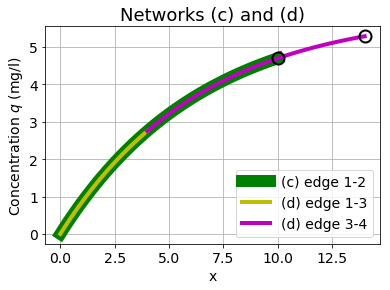

5.289531045335698 5.289531045335698


In [34]:
# Present all calculations in gm/l as opposed to kg/m^3

fig = plt.figure()
plot = fig.add_subplot(111)

xm0 = r_[0:lengths[0]:100j]
qm0 = 1000*q(ξ[0],ξ[1],Pe[0],Da[0],u,xm0,lengths[0])

xm1 = r_[0:lengths[1]:100j]
qm1 = 1000*q(ξ[2],ξ[3],Pe[1],Da[1],u,xm1,lengths[1])

xm2 = r_[0:lengths[2]:100j]
qm2 = 1000*q(ξ[4],ξ[5],Pe[2],Da[2],u,xm2,lengths[2])

xm3 = r_[0:lengths[3]:100j]
qm3 = 1000*q(ξ[6],ξ[7],Pe[3],Da[3],u,xm3,lengths[3])

length_ref = 10
Pe_ref = u*length_ref/D
Da_ref = (ψ/qR)*γ*length_ref/u
xm_ref  = r_[0:length_ref:100j]
qm_ref = 1000*q(-1,0,Pe_ref,Da_ref,u,xm_ref,length_ref)

plt.plot(xm_ref,qm_ref,'g-',linewidth=12)
plt.plot(xm0,qm0,'y-',linewidth=4)
plt.plot(xm2+xm0[-1],qm2,'m-',linewidth=4)

plt.plot(xm1[-1]+xm3[-1],qm3[-1],'ko',markersize=12,markerfacecolor='none',markeredgewidth=2)
plt.plot([10],qm_ref[-1],'ko',markersize=12,markerfacecolor='none',markeredgewidth=2)


plt.ylabel('Concentration $q$ (mg/l)',fontsize=14)
plt.xlabel('x',fontsize=14)
plt.title('Networks (c) and (d)',fontsize=18)
plt.legend(('(c) edge 1-2','(d) edge 1-3','(d) edge 3-4'),fontsize=14)
plot.tick_params(labelsize=14)
plt.grid()
plt.savefig('network_c_d.pdf')
plt.show()
print(qm2[-1],qm3[-1])

## Example 3: The larger network in the paper.

Edges    <br/>
0: 0-2   <br/>
1: 1-2  <br/>
2: 2-3   <br/>
3: 2-3*   <br/>
4: 3-4   <br/>
5: 3-5   <br/>

Robin BC's to enforce no incoming material from infinity.

In [19]:
β = 0.5

lengths = array([10*β,10*(1-β),20*β,20*(1-β),10*β,10*(1-β)])

edges = len(lengths)
Da,Pe,a,b,dca,dcb,dcalpha,dcbeta = matrixComponents(lengths,u,D,γ,ψ)

eqns   = 2*edges
M      = np.zeros((eqns,eqns))
rhs    = np.zeros(eqns)

# Input from node 0 is known (q0).
eqn = 0
edge = 0
M[eqn,2*edge] = 1
M[eqn,2*edge+1] = 1
rhs[eqn] = q0/qR - 1

# Input from node 1 is known (q0).
eqn = 1
edge = 1
M[eqn,2*edge] = 1
M[eqn,2*edge+1] = 1
rhs[eqn] = q0/qR - 1

# No net flux at node 2.
# Edges 0-2, 1-2, 2-3 and 2-3*.
# We have to take into account which end of the edge
eqn = 2

edge = 0
M[eqn,2*edge]   = a[edge]*qR*dca[edge]
M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
edge = 1
M[eqn,2*edge]   = a[edge]*qR*dca[edge]
M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
edge = 2
M[eqn,2*edge]   = -qR*dca[edge]
M[eqn,2*edge+1] = -qR*dcb[edge]
edge = 3
M[eqn,2*edge]   = -qR*dca[edge]
M[eqn,2*edge+1] = -qR*dcb[edge]

rhs[eqn] = 0

# Continuity of concentration at node 2, convergence of four edges.

eqn = 3

edge = 0
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 1
M[eqn,2*edge]   = -a[edge]
M[eqn,2*edge+1] = -b[edge]

rhs[eqn] = 0


eqn = 4

edge = 0
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 2
M[eqn,2*edge]   = -1
M[eqn,2*edge+1] = -1

rhs[eqn] = 0


eqn = 5

edge = 0
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 3
M[eqn,2*edge]   = -1
M[eqn,2*edge+1] = -1

rhs[eqn] = 0

# No net flux at node 3.
# Edges 2-3, 2-3*, 3-4 and 3-5.
# We have to take into account which end of the edge
eqn = 6

edge = 2
M[eqn,2*edge]   = a[edge]*qR*dca[edge]
M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
edge = 3
M[eqn,2*edge]   = a[edge]*qR*dca[edge]
M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
edge = 4
M[eqn,2*edge]   = -qR*dca[edge]
M[eqn,2*edge+1] = -qR*dcb[edge]
edge = 5
M[eqn,2*edge]   = -qR*dca[edge]
M[eqn,2*edge+1] = -qR*dcb[edge]

rhs[eqn] = 0

# Continuity of concentration at node 3, convergence of four edges.

eqn = 7

edge = 2
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 3
M[eqn,2*edge]   = -a[edge]
M[eqn,2*edge+1] = -b[edge]

rhs[eqn] = 0


eqn = 8

edge = 2
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 4
M[eqn,2*edge]   = -1
M[eqn,2*edge+1] = -1

rhs[eqn] = 0


eqn = 9

edge = 2
M[eqn,2*edge]   = a[edge]
M[eqn,2*edge+1] = b[edge]

edge = 5
M[eqn,2*edge]   = -1
M[eqn,2*edge+1] = -1

rhs[eqn] = 0

# Robin conditions on q at the ends of edges 2 and 3.
eqn = 10

edge = 4
M[eqn,2*edge]   = 0
M[eqn,2*edge+1] = 1

rhs[eqn] = 0


eqn = 11

edge = 5
M[eqn,2*edge]   = 0
M[eqn,2*edge+1] = 1

rhs[eqn] = 0

print(cond(M))

86799.73093679547


In [20]:
ξ = np.linalg.solve(M, rhs)
print(ξ)

[-1.00000000e+00 -9.01335710e-18 -1.00000000e+00 -9.01335710e-18
 -4.62549488e-01  3.44021338e-19 -4.62549488e-01  3.44021338e-19
 -9.89634013e-02  0.00000000e+00 -9.89634013e-02  0.00000000e+00]


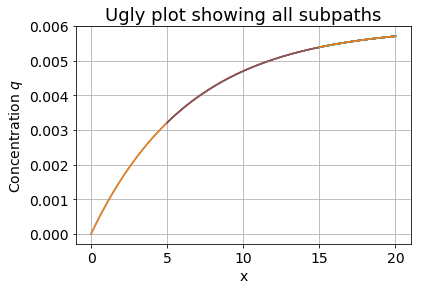

In [21]:
fig = plt.figure()
plot = fig.add_subplot(111)

xm0 = r_[0:lengths[0]:100j]
qm0 = q(ξ[0],ξ[1],Pe[0],Da[0],u,xm0,lengths[0])

xm1 = r_[0:lengths[1]:100j]
qm1 = q(ξ[2],ξ[3],Pe[1],Da[1],u,xm1,lengths[1])

xm2 = r_[0:lengths[2]:100j]
qm2 = q(ξ[4],ξ[5],Pe[2],Da[2],u,xm2,lengths[2])

xm3 = r_[0:lengths[3]:100j]
qm3 = q(ξ[6],ξ[7],Pe[3],Da[3],u,xm3,lengths[3])

xm4 = r_[0:lengths[5]:100j]
qm4 = q(ξ[8],ξ[9],Pe[4],Da[4],u,xm4,lengths[4])

xm5 = r_[0:lengths[5]:100j]
qm5 = q(ξ[10],ξ[11],Pe[5],Da[5],u,xm5,lengths[5])

plt.plot(xm0,qm0)
plt.plot(xm1,qm1)

plt.plot(xm2+xm0[-1],qm2)
plt.plot(xm3+xm0[-1],qm3)

plt.plot(xm2+xm1[-1],qm2)
plt.plot(xm3+xm1[-1],qm3)

plt.plot(xm4+xm2[-1]+xm0[-1],qm4)
plt.plot(xm5+xm2[-1]+xm0[-1],qm5)
plt.plot(xm4+xm2[-1]+xm0[-1],qm4)
plt.plot(xm5+xm2[-1]+xm0[-1],qm5)
plt.plot(xm4+xm2[-1]+xm1[-1],qm4)
plt.plot(xm5+xm2[-1]+xm1[-1],qm5)
plt.plot(xm4+xm2[-1]+xm1[-1],qm4)
plt.plot(xm5+xm2[-1]+xm1[-1],qm5)

plt.plot(xm4+xm3[-1]+xm0[-1],qm4)
plt.plot(xm5+xm3[-1]+xm0[-1],qm5)
plt.plot(xm4+xm3[-1]+xm0[-1],qm4)
plt.plot(xm5+xm3[-1]+xm0[-1],qm5)
plt.plot(xm4+xm3[-1]+xm1[-1],qm4)
plt.plot(xm5+xm3[-1]+xm1[-1],qm5)
plt.plot(xm4+xm3[-1]+xm1[-1],qm4)
plt.plot(xm5+xm3[-1]+xm1[-1],qm5)
plt.ylabel('Concentration $q$',fontsize=14)
plt.xlabel('x',fontsize=14)
plt.title('Ugly plot showing all subpaths',fontsize=18)
#plt.legend(('Edge 1-3','Edge 3-4','Edge 4-5'),fontsize=14)
plt.grid()
plot.tick_params(labelsize=14)
plt.savefig('ugly_plot.pdf')
plt.show()


## A systematic study to study breaksthrough as a function of asymmetry.


Edges    <br/>
0: 0-2   <br/>
1: 1-2  <br/>
2: 2-3   <br/>
3: 2-3*   <br/>
4: 3-4   <br/>
5: 3-5   <br/>

Robin BC's to enforce no incoming material from infinity.

In [22]:
β_list    = r_[0.1:0.5:20j]

q_through = zeros(len(β_list))
paths = zeros((len(β_list),8))
ind       = 0

for β in β_list:

    lengths = array([8*β,8*(1-β),20*β,20*(1-β),12*β,12*(1-β)])

    edges = len(lengths)
    Da,Pe,a,b,dca,dcb,dcalpha,dcbeta = matrixComponents(lengths,u,D,γ,ψ)

    eqns   = 2*edges
    M      = np.zeros((eqns,eqns))
    rhs    = np.zeros(eqns)

    # Input from node 0 is known (q0).
    eqn = 0
    edge = 0
    M[eqn,2*edge] = 1
    M[eqn,2*edge+1] = 1
    rhs[eqn] = q0/qR - 1

    # Input from node 1 is known (q0).
    eqn = 1
    edge = 1
    M[eqn,2*edge] = 1
    M[eqn,2*edge+1] = 1
    rhs[eqn] = q0/qR - 1

    # No net flux at node 2.
    # Edges 0-2, 1-2, 2-3 and 2-3*.
    # We have to take into account which end of the edge
    eqn = 2

    edge = 0
    M[eqn,2*edge]   = a[edge]*qR*dca[edge]
    M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
    edge = 1
    M[eqn,2*edge]   = a[edge]*qR*dca[edge]
    M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
    edge = 2
    M[eqn,2*edge]   = -qR*dca[edge]
    M[eqn,2*edge+1] = -qR*dcb[edge]
    edge = 3
    M[eqn,2*edge]   = -qR*dca[edge]
    M[eqn,2*edge+1] = -qR*dcb[edge]

    rhs[eqn] = 0

    # Continuity of concentration at node 2, convergence of four edges.

    eqn = 3

    edge = 0
    M[eqn,2*edge]   = a[edge]
    M[eqn,2*edge+1] = b[edge]

    edge = 1
    M[eqn,2*edge]   = -a[edge]
    M[eqn,2*edge+1] = -b[edge]

    rhs[eqn] = 0


    eqn = 4

    edge = 0
    M[eqn,2*edge]   = a[edge]
    M[eqn,2*edge+1] = b[edge]

    edge = 2
    M[eqn,2*edge]   = -1
    M[eqn,2*edge+1] = -1

    rhs[eqn] = 0


    eqn = 5

    edge = 0
    M[eqn,2*edge]   = a[edge]
    M[eqn,2*edge+1] = b[edge]

    edge = 3
    M[eqn,2*edge]   = -1
    M[eqn,2*edge+1] = -1

    rhs[eqn] = 0

    # No net flux at node 3.
    # Edges 2-3, 2-3*, 3-4 and 3-5.
    # We have to take into account which end of the edge
    eqn = 6

    edge = 2
    M[eqn,2*edge]   = a[edge]*qR*dca[edge]
    M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
    edge = 3
    M[eqn,2*edge]   = a[edge]*qR*dca[edge]
    M[eqn,2*edge+1] = b[edge]*qR*dcb[edge]
    edge = 4
    M[eqn,2*edge]   = -qR*dca[edge]
    M[eqn,2*edge+1] = -qR*dcb[edge]
    edge = 5
    M[eqn,2*edge]   = -qR*dca[edge]
    M[eqn,2*edge+1] = -qR*dcb[edge]

    rhs[eqn] = 0

    # Continuity of concentration at node 3, convergence of four edges.

    eqn = 7

    edge = 2
    M[eqn,2*edge]   = a[edge]
    M[eqn,2*edge+1] = b[edge]

    edge = 3
    M[eqn,2*edge]   = -a[edge]
    M[eqn,2*edge+1] = -b[edge]

    rhs[eqn] = 0


    eqn = 8

    edge = 2
    M[eqn,2*edge]   = a[edge]
    M[eqn,2*edge+1] = b[edge]

    edge = 4
    M[eqn,2*edge]   = -1
    M[eqn,2*edge+1] = -1

    rhs[eqn] = 0


    eqn = 9

    edge = 2
    M[eqn,2*edge]   = a[edge]
    M[eqn,2*edge+1] = b[edge]

    edge = 5
    M[eqn,2*edge]   = -1
    M[eqn,2*edge+1] = -1

    rhs[eqn] = 0

    # Robin conditions on q at the ends of edges 2 and 3.
    eqn = 10

    edge = 4
    M[eqn,2*edge]   = 0
    M[eqn,2*edge+1] = 1

    rhs[eqn] = 0


    eqn = 11

    edge = 5
    M[eqn,2*edge]   = 0
    M[eqn,2*edge+1] = 1

    rhs[eqn] = 0

    #print(cond(M))

    ξ = np.linalg.solve(M, rhs)

    xm4 = r_[0:lengths[4]:100j]
    qm4 = q(ξ[8],ξ[9],Pe[4],Da[4],u,xm4,lengths[4])

    xm5 = r_[0:lengths[5]:100j]
    qm5 = q(ξ[10],ξ[11],Pe[5],Da[5],u,xm5,lengths[5])
    
    q_through[ind] = (qm4[-1]+qm5[-1])/2
    paths[ind,0] = lengths[0]+lengths[2]+lengths[4]
    paths[ind,1] = lengths[0]+lengths[2]+lengths[5]
    paths[ind,2] = lengths[0]+lengths[3]+lengths[4]
    paths[ind,3] = lengths[0]+lengths[3]+lengths[5]
    paths[ind,4] = lengths[1]+lengths[2]+lengths[4]
    paths[ind,5] = lengths[1]+lengths[2]+lengths[5]
    paths[ind,6] = lengths[1]+lengths[3]+lengths[4]
    paths[ind,7] = lengths[1]+lengths[3]+lengths[5]
    
    ind += 1



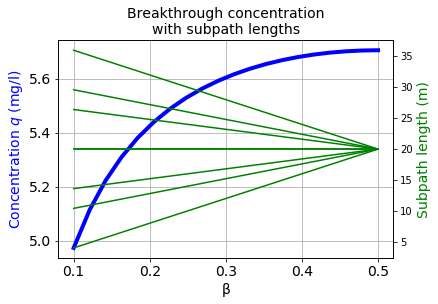

In [23]:
fig, ax1 = plt.subplots()
#fig.set_size_inches((6,4))

ax1.plot(β_list,1000*q_through,'b',linewidth=4)
ax2 = ax1.twinx()

ax2.plot(β_list,paths,'g')

ax1.set_xlabel('β',fontsize=14)
ax1.set_ylabel('Concentration $q$ (mg/l)',fontsize=14,color='b')
ax2.set_ylabel('Subpath length (m)',fontsize=14,color='g')
ax1.set_title('Breakthrough concentration\nwith subpath lengths',fontsize=14)
#plt.legend(('Edge 1-3','Edge 3-4','Edge 4-5'),fontsize=14)
ax1.grid()
ax1.tick_params(labelsize=14)
plt.savefig('breakthrough.pdf')
plt.show()